In [1]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from keras_video import VideoFrameGenerator
import glob

In [2]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [3]:

# classes = ["Backstroke", "Breaststroke", "Freestyle"]
with open('ucf101_data/classInd.txt') as f:
    classes = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
classes = [x.strip() for x in classes] 
classes.sort()
classes

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'Basketball',
 'BasketballDunk',
 'BenchPress',
 'Biking',
 'Billiards',
 'BlowDryHair',
 'BlowingCandles',
 'BodyWeightSquats',
 'Bowling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'BreastStroke',
 'BrushingTeeth',
 'CleanAndJerk',
 'CliffDiving',
 'CricketBowling',
 'CricketShot',
 'CuttingInKitchen',
 'Diving',
 'Drumming',
 'Fencing',
 'FieldHockeyPenalty',
 'FloorGymnastics',
 'FrisbeeCatch',
 'FrontCrawl',
 'GolfSwing',
 'Haircut',
 'HammerThrow',
 'Hammering',
 'HandstandPushups',
 'HandstandWalking',
 'HeadMassage',
 'HighJump',
 'HorseRace',
 'HorseRiding',
 'HulaHoop',
 'IceDancing',
 'JavelinThrow',
 'JugglingBalls',
 'JumpRope',
 'JumpingJack',
 'Kayaking',
 'Knitting',
 'LongJump',
 'Lunges',
 'MilitaryParade',
 'Mixing',
 'MoppingFloor',
 'Nunchucks',
 'ParallelBars',
 'PizzaTossing',
 'PlayingCello',
 'PlayingDaf',
 'PlayingDhol',
 'PlayingFlute',
 'Play

In [15]:

img_height , img_width = 64, 64

In [5]:
# some global params
SIZE = (img_height, img_width)
CHANNELS = 3
NBFRAME =20
BS = 9537
# pattern to get videos and classes
glob_pattern='ucf101_data/train/{classname}/*.avi'
# for data augmentation
data_aug = ImageDataGenerator(
#     zoom_range=1.5,
#     horizontal_flip=True,
#     rotation_range=8,
#     width_shift_range=.2,
#     height_shift_range=.2
)
# Create video frame generator

train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
#     split_val=0.25, 
#     shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
#     transformation=data_aug,
    use_frame_cache=True)

Total data: 101 classes for 9537 files for train


In [42]:

glob_test='ucf101_data/test/{classname}/*.avi'
valid = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_test,
    nb_frames=NBFRAME,
#     split=.2, 
    shuffle=True,
    batch_size=3783,
    target_shape=SIZE,
    nb_channel=CHANNELS,
#     transformation=data_aug,
    use_frame_cache=True)

Total data: 101 classes for 3783 files for train


In [43]:
valid = train.get_validation_generator()

Total data: 101 classes for 0 files for validation


In [11]:
train

In [6]:
import time
start_time = time.time()
x_train, y_train = next(train)
# x_test, y_test = next(valid)

elapsed_time = time.time() - start_time

In [7]:

print(str(elapsed_time/60)+' minutes')

5.051668866475423 minutes


In [14]:
x_train.shape

(9537, 20, 64, 64, 3)

In [ ]:
len(classes)

In [ ]:
# data_dir = "ucf101_data/train"
# img_height , img_width = 200, 180
# seq_len = 60
 
# #  Creating frames from videos
# def frames_extraction(video_path):
#     frames_list = []
     
#     vidObj = cv2.VideoCapture(video_path)
#     # Used as counter variable 
#     count = 1
 
#     while count <= seq_len: 
         
#         success, image = vidObj.read() 
#         if success:
#             image = cv2.resize(image, (img_height, img_width))
#             frames_list.append(image)
#             count += 1
#         else:
#             print("Defected frame")
#             break
 
            
#     return frames_list
 
# def create_data(input_dir):
#     X = []
#     Y = []
     
#     classes_list = os.listdir(input_dir)
     
#     for c in classes_list:
#         print(c)
#         files_list = os.listdir(os.path.join(input_dir, c))
#         for f in files_list:
#             frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
#             if len(frames) == seq_len:
#                 X.append(frames)
             
#                 y = [0]*len(classes)
#                 y[classes.index(c)] = 1
#                 Y.append(y)
     
#     X = np.asarray(X)
#     Y = np.asarray(Y)
#     return X, Y
 
# X, Y = create_data(data_dir)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, shuffle=True, random_state=0)

In [17]:

filepath = 'best_model_convlstm_fix.h5'
'''
model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (5, 5), padding='same',return_sequences = True, data_format = "channels_last", 
                     input_shape = (NBFRAME, img_width, img_height, 3),kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
# model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), padding='same',return_sequences = True, data_format = "channels_last", 
#                      input_shape = (NBFRAME,64,64, 3)))
model.add(Dropout(0.5))
model.add(ConvLSTM2D(filters = 32, kernel_size = (5, 5), return_sequences = False, data_format = "channels_last",kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(len(classes), activation = "softmax"))
 
model.summary()
'''
model = Sequential()
# input_shape: (time_steps, map_height, map_width, channels)
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3),  input_shape = (NBFRAME, img_width, img_height, 3), return_sequences = True))
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), return_sequences = True))
model.add(BatchNormalization())
#model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.2))


model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), return_sequences = True))
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), return_sequences = True))
model.add(BatchNormalization())
#model.add(LeakyReLU(alpha=0.2))
model.add(MaxPooling3D((1, 2, 2)))
model.add(Dropout(0.2))

model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), return_sequences = True))
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), return_sequences = True))
model.add(BatchNormalization())
#model.add(LeakyReLU(alpha=0.2))
#model.add(AveragePooling3D((1, 2, 2)))
model.add(Dropout(0.2))

model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), return_sequences = True))
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), return_sequences = False))
model.add(BatchNormalization())
#model.add(LeakyReLU(alpha=0.2))
model.add(AveragePooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(classes), activation='softmax'))
model.summary()

opt = optimizers.Adam(lr=0.00005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)
stop = EarlyStopping(monitor='val_loss', patience =5,
                      verbose=0, mode='auto', baseline=None, 
                      restore_best_weights=False)
callbacks = [checkpoint,stop]
 
history = model.fit(x = X_train, y = y_train, epochs=400, batch_size = 2 , shuffle=True, validation_data=(X_test,y_test), callbacks=callbacks)
# history = model.fit_generator(
#     train,
#     validation_data=valid,
#     verbose=1,
#     epochs=400, 
#     callbacks=callbacks
# )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 20, 62, 62, 32)    40448     
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 20, 60, 60, 32)    73856     
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 60, 60, 32)    128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 60, 60, 32)    0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 20, 58, 58, 32)    73856     
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 20, 56, 56, 32)    73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 56, 56, 32)   

3576/3576 [==============================] - ETA: 0s - loss: 1.0384 - accuracy: 0.7254
Epoch 00015: val_loss improved from 1.68302 to 1.62217, saving model to best_model_convlstm_fix.h5
3576/3576 [==============================] - 1217s 340ms/step - loss: 1.0384 - accuracy: 0.7254 - val_loss: 1.6222 - val_accuracy: 0.6029
Epoch 16/400
3576/3576 [==============================] - ETA: 0s - loss: 0.9412 - accuracy: 0.7418
Epoch 00016: val_loss improved from 1.62217 to 1.57823, saving model to best_model_convlstm_fix.h5
3576/3576 [==============================] - 1234s 345ms/step - loss: 0.9412 - accuracy: 0.7418 - val_loss: 1.5782 - val_accuracy: 0.6239
Epoch 17/400
3576/3576 [==============================] - ETA: 0s - loss: 0.8128 - accuracy: 0.7763
Epoch 00017: val_loss did not improve from 1.57823
3576/3576 [==============================] - 1239s 347ms/step - loss: 0.8128 - accuracy: 0.7763 - val_loss: 1.5979 - val_accuracy: 0.6147
Epoch 18/400
3576/3576 [==========================

In [ ]:
# y_pred = model.predict(X_test)
# y_pred = np.argmax(y_pred, axis = 1)
# # y_test = np.argmax(y_test, axis = 1)
 
# print(classification_report(y_test, y_pred))

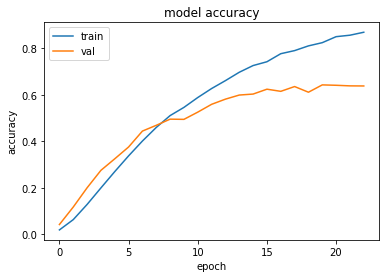

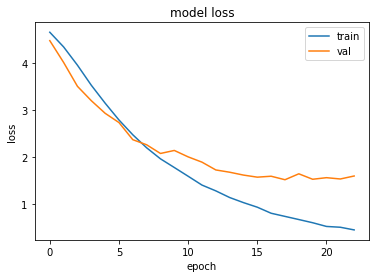

In [22]:
# use LSTM model to predict

# import seaborn as sns
import matplotlib.pyplot as plt
# y_pred_ohe = model.predict(X_test)
# y_pred_labels = np.argmax(y_pred_ohe, axis=1)
# y_true_labels = y_test
# confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
# print(y_true_labels)

# plt.figure(figsize=(8, 6))
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
# sns.heatmap(confusion_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show();

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.savefig('model-acc.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.savefig('model-loss.png')
plt.show()

In [ ]:
model.save("model_har.h5")